In [1]:
#from data_generator import dgen, pack_by_value, downscale_nsave, Camera_source, data_generator, dir_source, resize_tuple
from sources.Camera import thr_camera
#from fit_pca import plot_images_table, get_pca_sk_transformer

import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

import os, time, shutil

from IPython import display

%load_ext autoreload
%autoreload 2

In [2]:
try:
    cam.release()
except:pass
cam = cv2.VideoCapture(0)

## Just view the camera

qsize 15
qsize 16
qsize 17
qsize 18
qsize 19
qsize 20
qsize 21
qsize 22
qsize 23
qsize 24
qsize 25


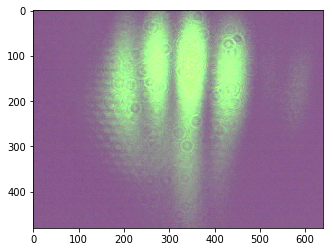

qsize 26
qsize 1
qsize 2
qsize 3
qsize 4
qsize 5
qsize 6
qsize 7
qsize 8
qsize 9
qsize 10
qsize 11
qsize 12
qsize 13


KeyboardInterrupt: 

qsize 14
qsize 15
qsize 16
qsize 17
qsize 18
qsize 19
qsize 20
qsize 21
qsize 22
qsize 23
qsize 24
qsize 25
qsize 26
qsize 27
qsize 28
qsize 29
qsize 30
qsize 31
qsize 32
qsize 33
qsize 34
qsize 35
qsize 36
qsize 37
qsize 38
qsize 39
qsize 40
qsize 41
qsize 42
qsize 43
qsize 44
qsize 45
qsize 46


In [3]:
gen, p = thr_camera(cam, q_size=0)
im_prev = np.zeros((10,10))
for im in gen:
    if im is not None:
        im_prev = im
        continue
    else:
        time.sleep(.4)
        display.clear_output()
        plt.imshow(im_prev)
        plt.show()
    

In [3]:
# an optional path of where to save data
path = "D:\LabData\img"


In [3]:
#from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

In [90]:
from data_generator import resize_gen

def time_gen():
    start = time.time()
    while True:
        yield time.time() - start
        

def packer(gen,delay=0.1, size = 20):
    """ appends and yields if got none """
    start = time.time()
    pack= []
    for im in gen:
        if im is not None:
            pack.append(im)
        else:
            print("none")
            time.sleep(delay)
        if len(pack)>size:
            yield pack
            pack= []
        else:
            print(2,len(pack))
            
def packer(gen,delay=0.1,size=12):
    """ appends and yields if got none """
    pack= []
    for im in gen:
        if im is not None:
            pack.append(im)
            continue
        else:
            time.sleep(delay)
            if len(pack)>size:
                yield pack
                pack=[]
def pipeline():
    gen, p = thr_camera(cam)
    res = resize_gen(gen, factor=0.3)
    x = packer(res)
    y = time_gen()
    xy = zip(x,y)
    xy = ((x, np.ones(len(x))*y) for x,y in xy)
    return xy
    

In [91]:
transformer = IncrementalPCA(
    n_components=10,
    batch_size=200
)
#train_gen = pipeline()
def remove_random(arr, count):
    count = min(len(arr),count)
    for i in range(count):
        arr.pop(random.randrange(len(arr)))
    return arr
    
def cached_random_gen(gen, cache_size=3000):
    cache = []
    for x,y in gen:
        if len(cache)>cache_size:
            cache = remove_random(cache, count=len(x))
        for xy in zip(x,y):
            cache.append(xy)
        xs = [x for x,y in cache]
        ys = [y for x,y in cache]
        xs,ys = np.array(xs),np.array(ys)
        yield xs,ys
        
def transformed_gen(gen):
    for im, y in gen:
        print('len',len(im), 'sh', im[0].shape)
        vec = np.array([i.flatten() for i in im])
        #print(vec.shape)
        transformer.partial_fit(vec)
        x = transformer.transform(vec)
        var = transformer.explained_variance_ratio_
        print(sum(var),var[:5])
        y = y/100
        yield x, y
        
def printer(gen):
    for x,y in gen:
        print('shapes',x.shape,y.shape)
        print('means',np.mean(x), np.mean(y))
        print('stds',np.std(x), np.std(y))
        yield x,y
    

In [92]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Input, Flatten, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

In [94]:
#layers
inp_s = 10
first = 10
second = 5
out = 1

In [95]:
inp = Input(shape = [inp_s])
x = BatchNormalization()(inp)
x = Dense(first, activation='relu')(x)
x = Dense(second, activation='relu')(x)
x = Dense(out, activation='relu')(x)
model = Model(inp, x)
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)

model.compile(loss='mse',optimizer=opt)

In [96]:
gen = printer(
cached_random_gen(
transformed_gen(
pipeline()
) ) )
x,y=  next(gen)
print(x.shape)
print(y.shape)
model.fit_generator(
    gen,
    steps_per_epoch=100,
    epochs = 20,
 )
         # validation_data=(X_train[validate], y_train[validate]))

len 14 sh (144, 192, 3)
0.9893104875242581 [0.93185565 0.01569134 0.00870805 0.00585948 0.00518252]
shapes (14, 10) (14,)
means -6.496390726949487e-14 2.6226043701171882e-08
stds 1252.337770933992 6.617444900424222e-24
(14, 10)
(14,)
Epoch 1/20
len 13 sh (144, 192, 3)
0.9495596170682419 [0.87732896 0.02341594 0.01533488 0.00705527 0.00542817]
shapes (27, 10) (27,)
means -85.41712900415989 0.007682514367280184
stds 961.3208125838293 0.007972494718927978
  1/100 [..............................] - ETA: 3:35 - loss: 1.2258e-04len 16 sh (144, 192, 3)
0.9020024207372042 [0.8065772  0.03528529 0.02215447 0.01062051 0.00610142]
shapes (43, 10) (43,)
means -110.93259415459087 0.016952532945677293
stds 797.4784766688209 0.013598622703109233
  2/100 [..............................] - ETA: 2:27 - loss: 2.9745e-04len 15 sh (144, 192, 3)
0.8636399295322077 [0.74168653 0.05741326 0.02772823 0.0104456  0.00578213]
shapes (58, 10) (58,)
means -111.85479885517508 0.024707880307888164
stds 706.0424296760

 29/100 [=======>......................] - ETA: 1:49 - loss: 0.0148len 14 sh (144, 192, 3)
0.8513567636512774 [0.70101624 0.08704975 0.02597186 0.01887157 0.00628344]
shapes (430, 10) (430,)
means -200.2735681855621 0.23527905999228016
stds 774.7707410409606 0.14018943427531433
 30/100 [========>.....................] - ETA: 1:48 - loss: 0.0148len 14 sh (144, 192, 3)
0.8487658206621183 [0.6992444  0.08574505 0.02650145 0.01874705 0.00620841]
shapes (444, 10) (444,)
means -198.2936472317487 0.24299390242443428
stds 767.7138583146696 0.14443497875100053
 31/100 [========>.....................] - ETA: 1:46 - loss: 0.0148len 15 sh (144, 192, 3)
0.8459481486429267 [0.69780021 0.08445475 0.02652164 0.01859738 0.00614997]
shapes (459, 10) (459,)
means -196.06703510652295 0.2512810052506025
stds 760.011777680311 0.1490386785212031
 32/100 [========>.....................] - ETA: 1:45 - loss: 0.0148len 13 sh (144, 192, 3)
0.8432327472976174 [0.69559187 0.08352312 0.02657566 0.01866706 0.00615114

 59/100 [================>.............] - ETA: 1:02 - loss: 0.0146len 17 sh (144, 192, 3)
0.7719749155548528 [0.60611075 0.06868095 0.05444859 0.02330207 0.00593699]
shapes (850, 10) (850,)
means -152.6100916280728 0.46566872649753793
stds 605.7235199535739 0.26997981772081864
 60/100 [=================>............] - ETA: 1:01 - loss: 0.0148len 15 sh (144, 192, 3)
0.7693829955819039 [0.60221219 0.06871883 0.05443868 0.02456749 0.00591497]
shapes (865, 10) (865,)
means -151.5365348453383 0.4738459061446217
stds 601.6217644937736 0.2746164918065909
 61/100 [=================>............] - ETA: 59s - loss: 0.0151 len 13 sh (144, 192, 3)
0.7670896069184485 [0.59932159 0.06841415 0.05492803 0.02495223 0.00593886]
shapes (878, 10) (878,)
means -150.25315720040626 0.4809015957125227
stds 598.0114694249113 0.2785858469083292
 62/100 [=================>............] - ETA: 58s - loss: 0.0153len 13 sh (144, 192, 3)
0.764728439535518 [0.59656108 0.06821968 0.05479593 0.0255501  0.00601874]
s

 89/100 [=========================>....] - ETA: 16s - loss: 0.0306len 14 sh (144, 192, 3)
0.7448644811769842 [0.54458866 0.08739931 0.06165858 0.02673572 0.00948381]
shapes (1258, 10) (1258,)
means -127.1039446010952 0.6880011366660721
stds 572.7371698713946 0.3969333886908787
 90/100 [==========================>...] - ETA: 15s - loss: 0.0315len 14 sh (144, 192, 3)
0.7485792912056904 [0.54718597 0.08609302 0.06311501 0.02718145 0.01020356]
shapes (1272, 10) (1272,)
means -126.79763037546797 0.6956312273170963
stds 579.2352124683273 0.40131450942653896
 91/100 [==========================>...] - ETA: 13s - loss: 0.0324len 13 sh (144, 192, 3)
0.7528969623664097 [0.54955264 0.08388907 0.06600067 0.0281594  0.0105609 ]
shapes (1285, 10) (1285,)
means -126.0502965299302 0.7027237698911228
stds 587.0667525479237 0.405396189814108
 92/100 [==========================>...] - ETA: 12s - loss: 0.0332len 13 sh (144, 192, 3)
0.7575273720801601 [0.5518979  0.08193934 0.06917054 0.02880746 0.01107203]

0.9004738350299496 [0.69886678 0.13277481 0.02667097 0.01980318 0.01091955]
shapes (1659, 10) (1659,)
means -148.05319782350227 0.905402729851859
stds 1053.9168286438023 0.5209694819109002
 19/100 [====>.........................] - ETA: 2:01 - loss: 0.1192len 13 sh (144, 192, 3)
0.9034260504760102 [0.70251272 0.13245309 0.02643549 0.01975696 0.01073216]
shapes (1672, 10) (1672,)
means -149.6218078922851 0.9124416444033526
stds 1073.7972760932626 0.5249969852435299
 20/100 [=====>........................] - ETA: 1:59 - loss: 0.1169len 13 sh (144, 192, 3)
0.9063929892965222 [0.70592325 0.13223722 0.02628359 0.01968779 0.01053546]
shapes (1685, 10) (1685,)
means -153.03887144420696 0.9194691122207868
stds 1093.5387789483555 0.5290057514962212
 21/100 [=====>........................] - ETA: 1:58 - loss: 0.1146len 13 sh (144, 192, 3)
0.9092947218971563 [0.70922562 0.132013   0.02620006 0.01958376 0.01032446]
shapes (1698, 10) (1698,)
means -156.41291574030453 0.9265205434256082
stds 1113.27

 48/100 [=============>................] - ETA: 1:17 - loss: 0.0878len 16 sh (144, 192, 3)
0.9488469295551109 [0.73868353 0.13619158 0.03475806 0.01171173 0.01133339]
shapes (2074, 10) (2074,)
means -252.6138595484516 1.1303316568615582
stds 1550.8233566900922 0.6500766826051638
 49/100 [=============>................] - ETA: 1:16 - loss: 0.0877len 14 sh (144, 192, 3)
0.9498175806437356 [0.73206488 0.14035816 0.03677289 0.01289672 0.01136829]
shapes (2088, 10) (2088,)
means -255.23022802026753 1.1378822833802051
stds 1569.2734186038192 0.6543791601106791
 50/100 [==============>...............] - ETA: 1:14 - loss: 0.0875len 13 sh (144, 192, 3)
0.9506107050238937 [0.72594351 0.14446573 0.0386675  0.01408057 0.01106769]
shapes (2101, 10) (2101,)
means -254.88840103648127 1.144900329370603
stds 1586.980833372936 0.6583868883985784
 51/100 [==============>...............] - ETA: 1:13 - loss: 0.0873len 13 sh (144, 192, 3)
0.9511537809943849 [0.71853133 0.14853911 0.04073523 0.01532302 0.010

 78/100 [======================>.......] - ETA: 32s - loss: 0.0742len 14 sh (144, 192, 3)
0.9705907109430488 [0.64524966 0.22851791 0.05320152 0.01774638 0.00972324]
shapes (2482, 10) (2482,)
means -263.27533835554453 1.351326079470414
stds 2090.6664067196025 0.7772850924181808
 79/100 [======================>.......] - ETA: 31s - loss: 0.0738len 13 sh (144, 192, 3)
0.9709429996942784 [0.64527986 0.22861696 0.05324916 0.0180291  0.00982394]
shapes (2495, 10) (2495,)
means -264.6045697956273 1.3583807109161943
stds 2102.693698972987 0.7813616001350094
 80/100 [=======================>......] - ETA: 29s - loss: 0.0733len 14 sh (144, 192, 3)
0.9712947319450381 [0.6452298  0.22863048 0.05338639 0.01840538 0.00991887]
shapes (2509, 10) (2509,)
means -266.08302494517744 1.3659740164851042
stds 2115.475025316853 0.7857447421200529
 81/100 [=======================>......] - ETA: 28s - loss: 0.0729len 13 sh (144, 192, 3)
0.9715887055976637 [0.64523149 0.22866674 0.05350402 0.01871414 0.00993693

KeyboardInterrupt: 

0.9759230850920068 [0.6418032  0.207431   0.07479915 0.02749952 0.00821717]
shapes (2871, 10) (2871,)
means -346.93790454485895 1.562348419327804
stds 2356.5240415542257 0.8991177320192769


[0.6418032  0.207431   0.07479915 0.02749952 0.00821717]


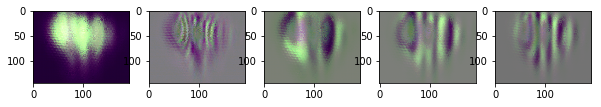

In [97]:
cmp = transformer.components_

cnt = 5
f, axs = plt.subplots(1,cnt, figsize=(10,15))
v0 = transformer.mean_
a = v0.reshape(144,192,3)
axs[0].imshow(a.astype(np.int))
for i, ax in enumerate(axs[1:]):
    v = cmp[i-1]
    a = v.reshape(144,192,3)
    a -= np.min(a)
    a *= 255/np.max(a)

    ax.imshow(a.astype(np.int))
print(transformer.explained_variance_ratio_[:5])

In [ ]:
now = time.time()
experiment_test = Dict2Obj({
    "start_time":now,  #time.mktime((2018,9,24,19,39,4,0,0,0)),
    "tick":10,
    "transition_dur":1,
})
source  = Levenh_source(path_test)
data_gen = data_generator(source,experiment_test)
resized = resize_tuple(data_gen)
pca_ed = pca_gen( (d[0][:,:,1] for d in resized) )
#predictor = model.predict_generator(pca_ed)
for x in pca_ed:
    x = np.array(x)/256
    pred = model.predict(x)
    print('predicted:',pred)


In [ ]:
from sklearn.externals import joblib # saving pca
_ = joblib.dump(pca, 'PCA'+str(n_components)+'.save')

In [ ]:
pca = joblib.load('PCA'+str(n_components)+'.save')

In [ ]:
transformed = pca.transform(X)

In [ ]:
transformed = transformed/transformed.max()


In [ ]:
angles = np.array([d[1] for d in data])
angles = angels - angels.min()
angles

In [ ]:
enc = OneHotEncoder()
enc.fit(angles.reshape(len(angles),1))
trAng = enc.transform(angles.reshape(len(angles),1))

In [ ]:
#X = [np.array(d.getdata()).flatten() for d in imgs]
X = np.array(X).reshape(len(X), 204, 256, 3)

import matplotlib.pyplot as plt
plt.imshow((X[0]).astype(np.uint8), interpolation='nearest')

In [ ]:
test = np.cumsum([0, 6, 7, 7, 7, 8, 7, 8, 7, 7, 6, 7, 7, 7])
train = np.delete(range(len(X)), test)

In [ ]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Input, Flatten, BatchNormalization
from keras.models import Model

In [ ]:
#layers
first = 20
second = 10
out = 1

In [ ]:
inp = Input(shape = (204, 256, 3))
x = MaxPooling2D((2, 2), padding='same')(inp)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((20, 20), padding='same')(x)
x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
#x = MaxPooling2D((10, 10), padding='same')(x)
x = Flatten()(x)
x = Dense(first, activation='relu')(x)
x = Dense(second, activation='relu')(x)
x = Dense(out, activation='relu')(x)
model = Model(inp, x)
model.compile(loss='mae', optimizer='adam')

In [ ]:
model.fit(X[train]/256, angles[train]%10/10, batch_size=4, epochs=300, shuffle=True, validation_data=(X[test]/256, angles[test]%10/10))

In [ ]:
pred = model.predict(X[test]/256)*10

In [ ]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(10, 10))
plot=fig.add_subplot(111)
plot.plot(range(len(pred)), pred[:, 0], 'ro-', ms=1)
plot.plot(range(len(pred)), angles[test]%10, 'bo-', ms=1)

In [ ]:
fig=plt.figure(figsize=(10, 10))
plot=fig.add_subplot(111)
plot.plot(angles[test]%10, pred[:, 0], 'ro', ms=10)

In [ ]:
import os
os.listdir('C:\\Users\\ЛФКИТ-3\\Documents\\quantTechLab\\data\\auto_rotate')